# Simple Example 

In [2]:
from common.ETLBase import PipelineBuilder, PipeConfigBuilder

In [3]:
config = PipeConfigBuilder()
pipe = PipelineBuilder(config)

In [8]:
config.setups(a=1,b=9)

In [14]:
config.setups(z=3)

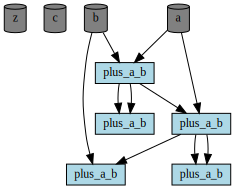

In [15]:
config.view()

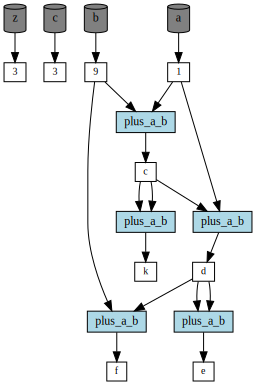

In [16]:
config.view(summary=False)

In [6]:
@pipe._func_
def plus_a_b(a=1,b=2):
    return a+b
#pipe._plus_a_b = plus_a_b

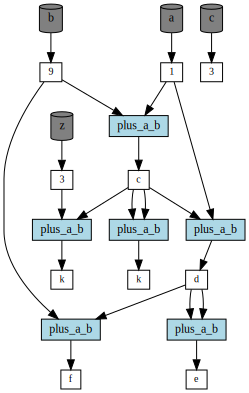

In [17]:
pipe.setup_connection('k = plus_a_b(c,b=z)')
pipe.view(summary=False)

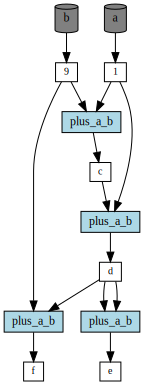

In [9]:
pipe.setup_connection('c = plus_a_b(a=a,b=b)')
pipe.setup_connection('d = plus_a_b(a=a,b=c)')
pipe.setup_connection('e = plus_a_b(d,d)')
pipe.setup_connection('f = plus_a_b(a=b,b=d)')
pipe.view(summary=False)

In [8]:
pipe.f.get()

20

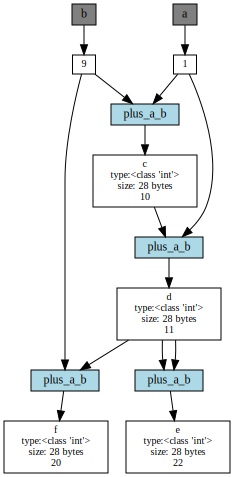

In [9]:
pipe.view(summary=False, option='all')

# Visualization of the Data Pipeline in an Experiment 

In [9]:
from experiments.ex3.connect_pipeline import pipe

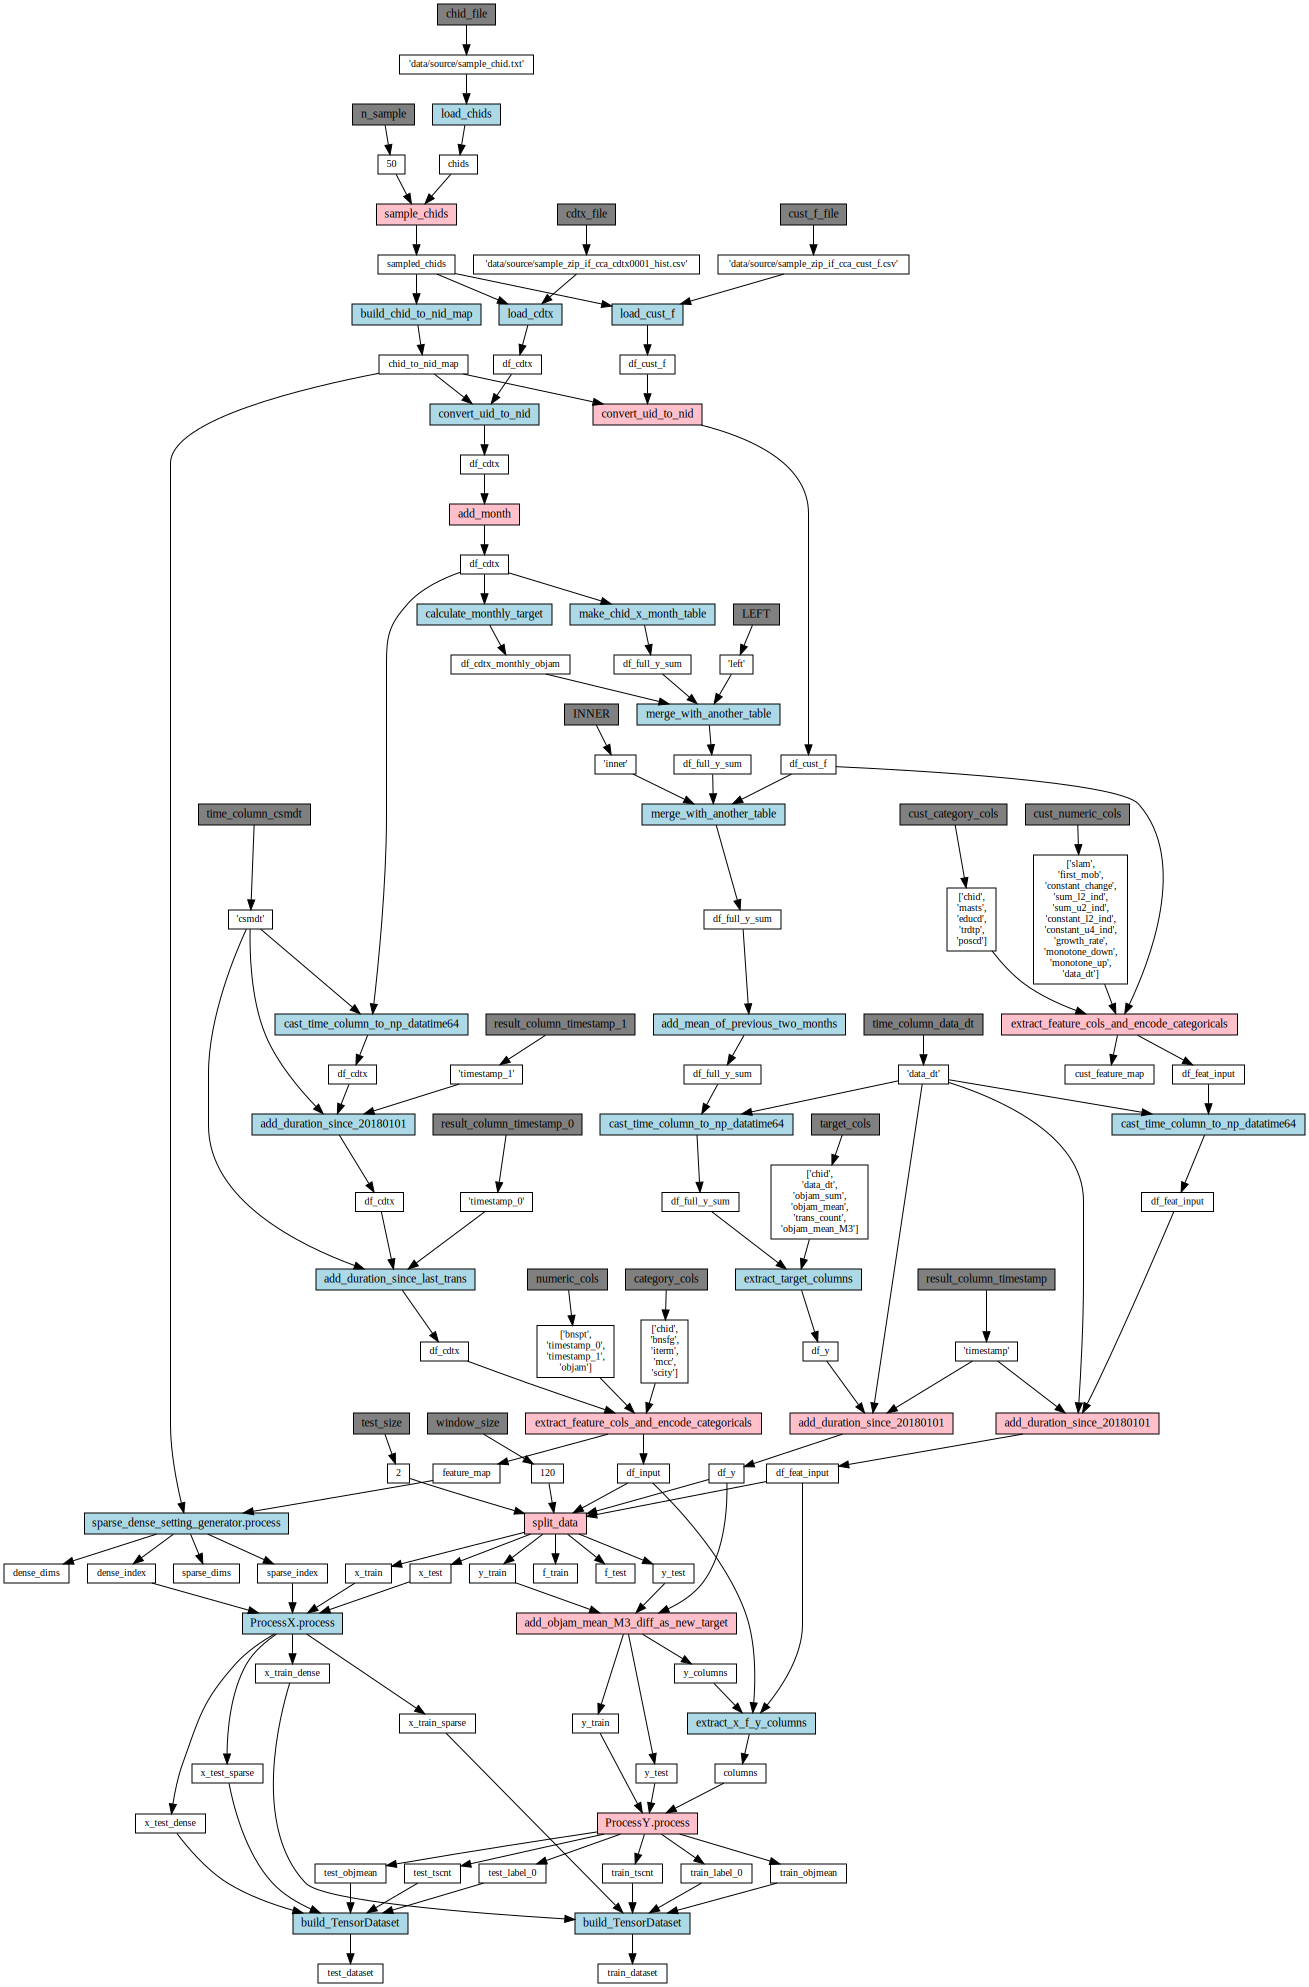

In [10]:
pipe.view(summary=False)

## checking dependency 

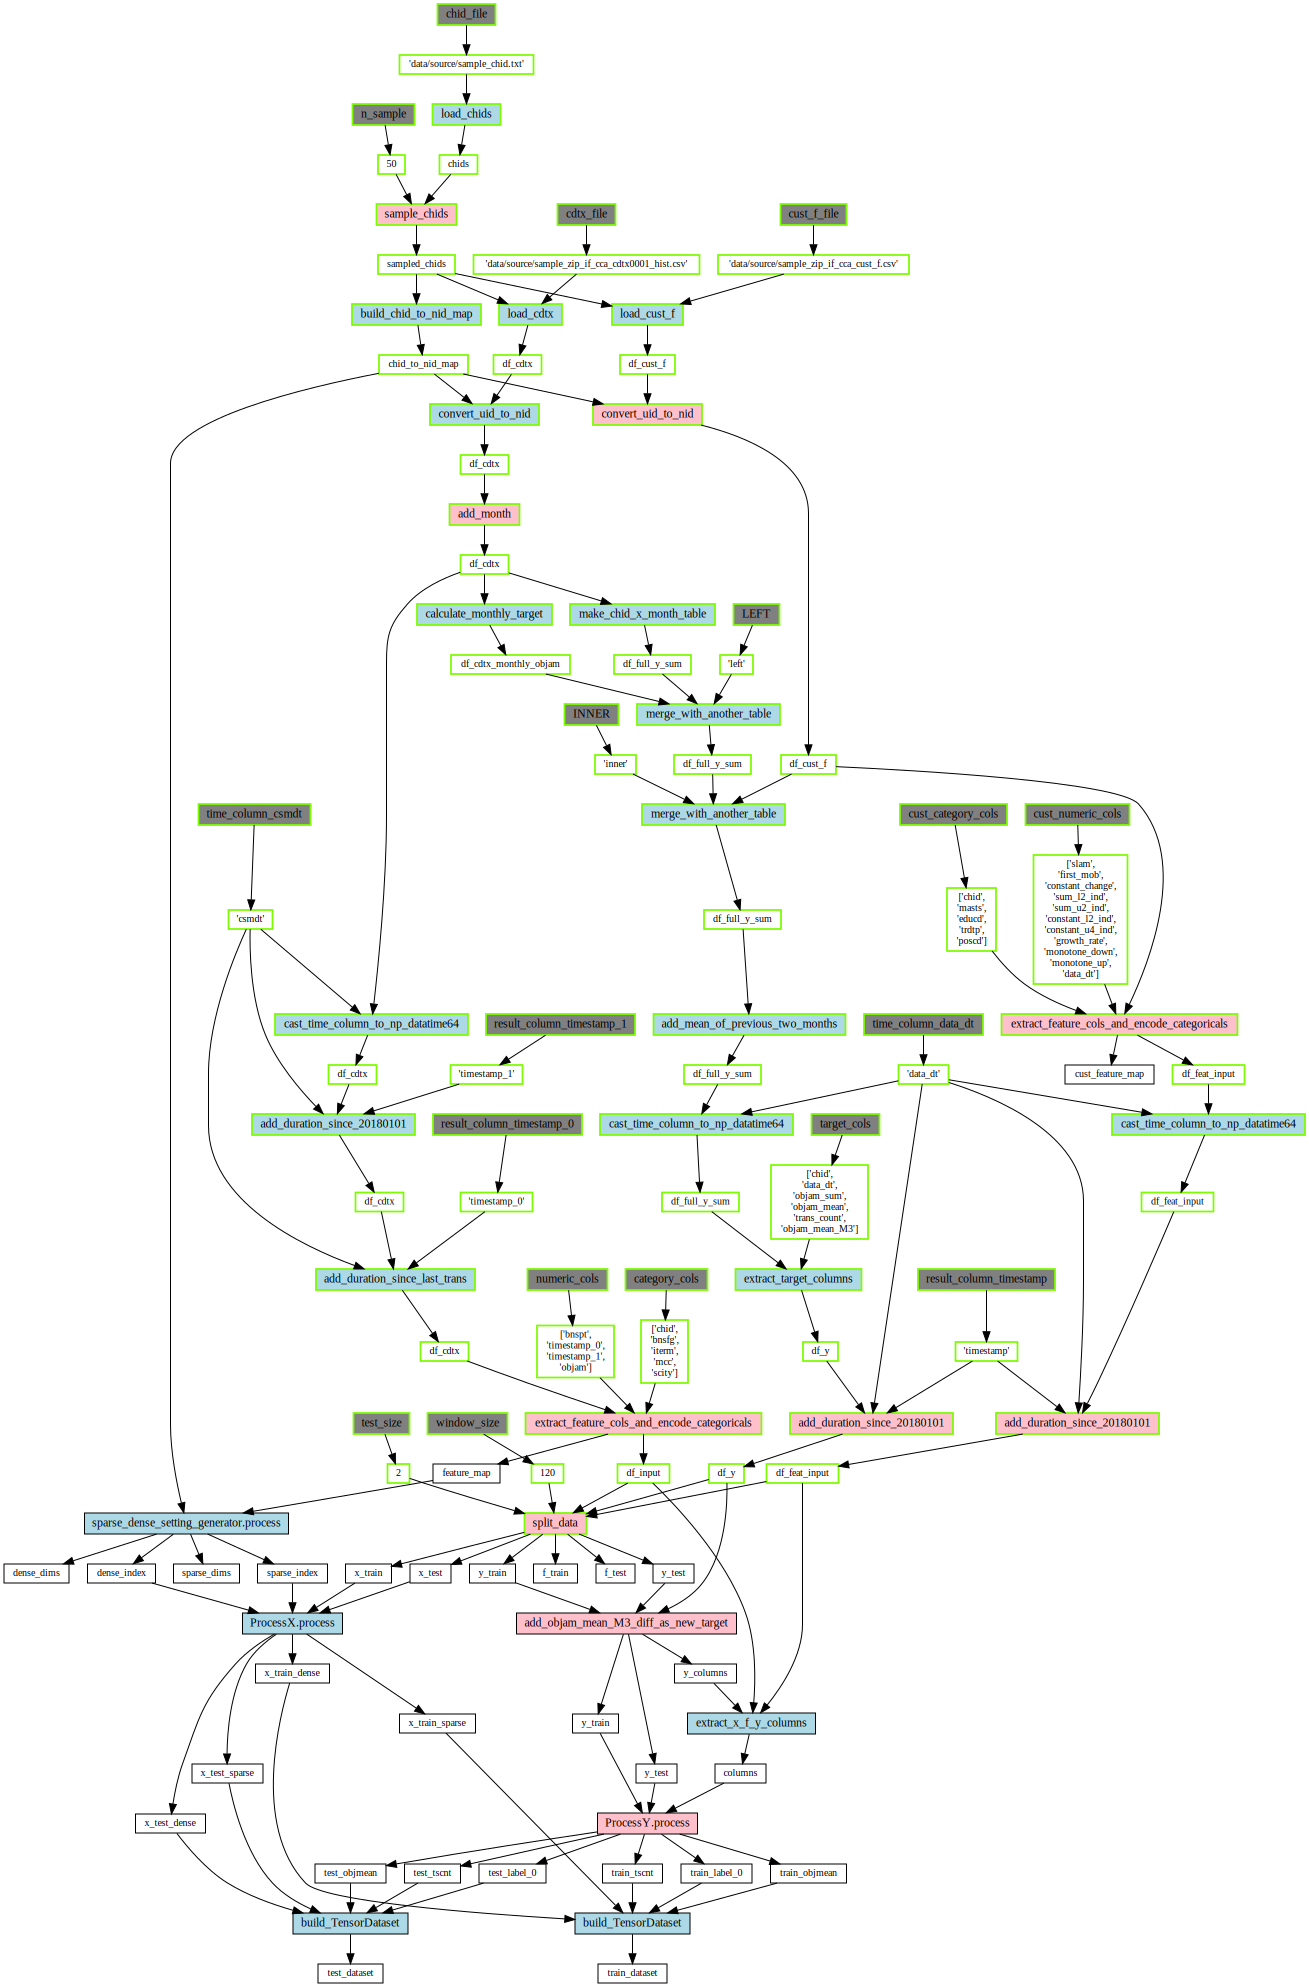

In [11]:
pipe.view_dependency('split_data',summary=False)

## viewing data content, size, and type 

loading time: 6.9595723152160645
loading time: 6.900240898132324
loading time: 6.75674843788147
list_chid, list_month calculated
[DELETE] df_cdtx
df_cdtx grouped
list_chid, list_month calculated
[DELETE] df_cdtx
df_cdtx grouped
loading time: 5.838204383850098
loading time: 5.308440446853638
list_chid, list_month calculated
[DELETE] df_cdtx
df_cdtx grouped
list_chid, list_month calculated
[DELETE] df_cdtx
df_cdtx grouped


100%|██████████| 50/50 [00:02<00:00, 16.68it/s]


list_chid, list_month calculated
[DELETE] df_cdtx
df_cdtx grouped


100%|██████████| 50/50 [00:02<00:00, 18.22it/s]
4804it [00:00, 1648755.13it/s]


list_chid, list_month calculated
[DELETE] df_cdtx
df_cdtx grouped


100%|██████████| 50/50 [00:02<00:00, 17.62it/s]


list_chid, list_month calculated
[DELETE] df_cdtx
df_cdtx grouped


100%|██████████| 50/50 [00:02<00:00, 17.77it/s]


Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Spa

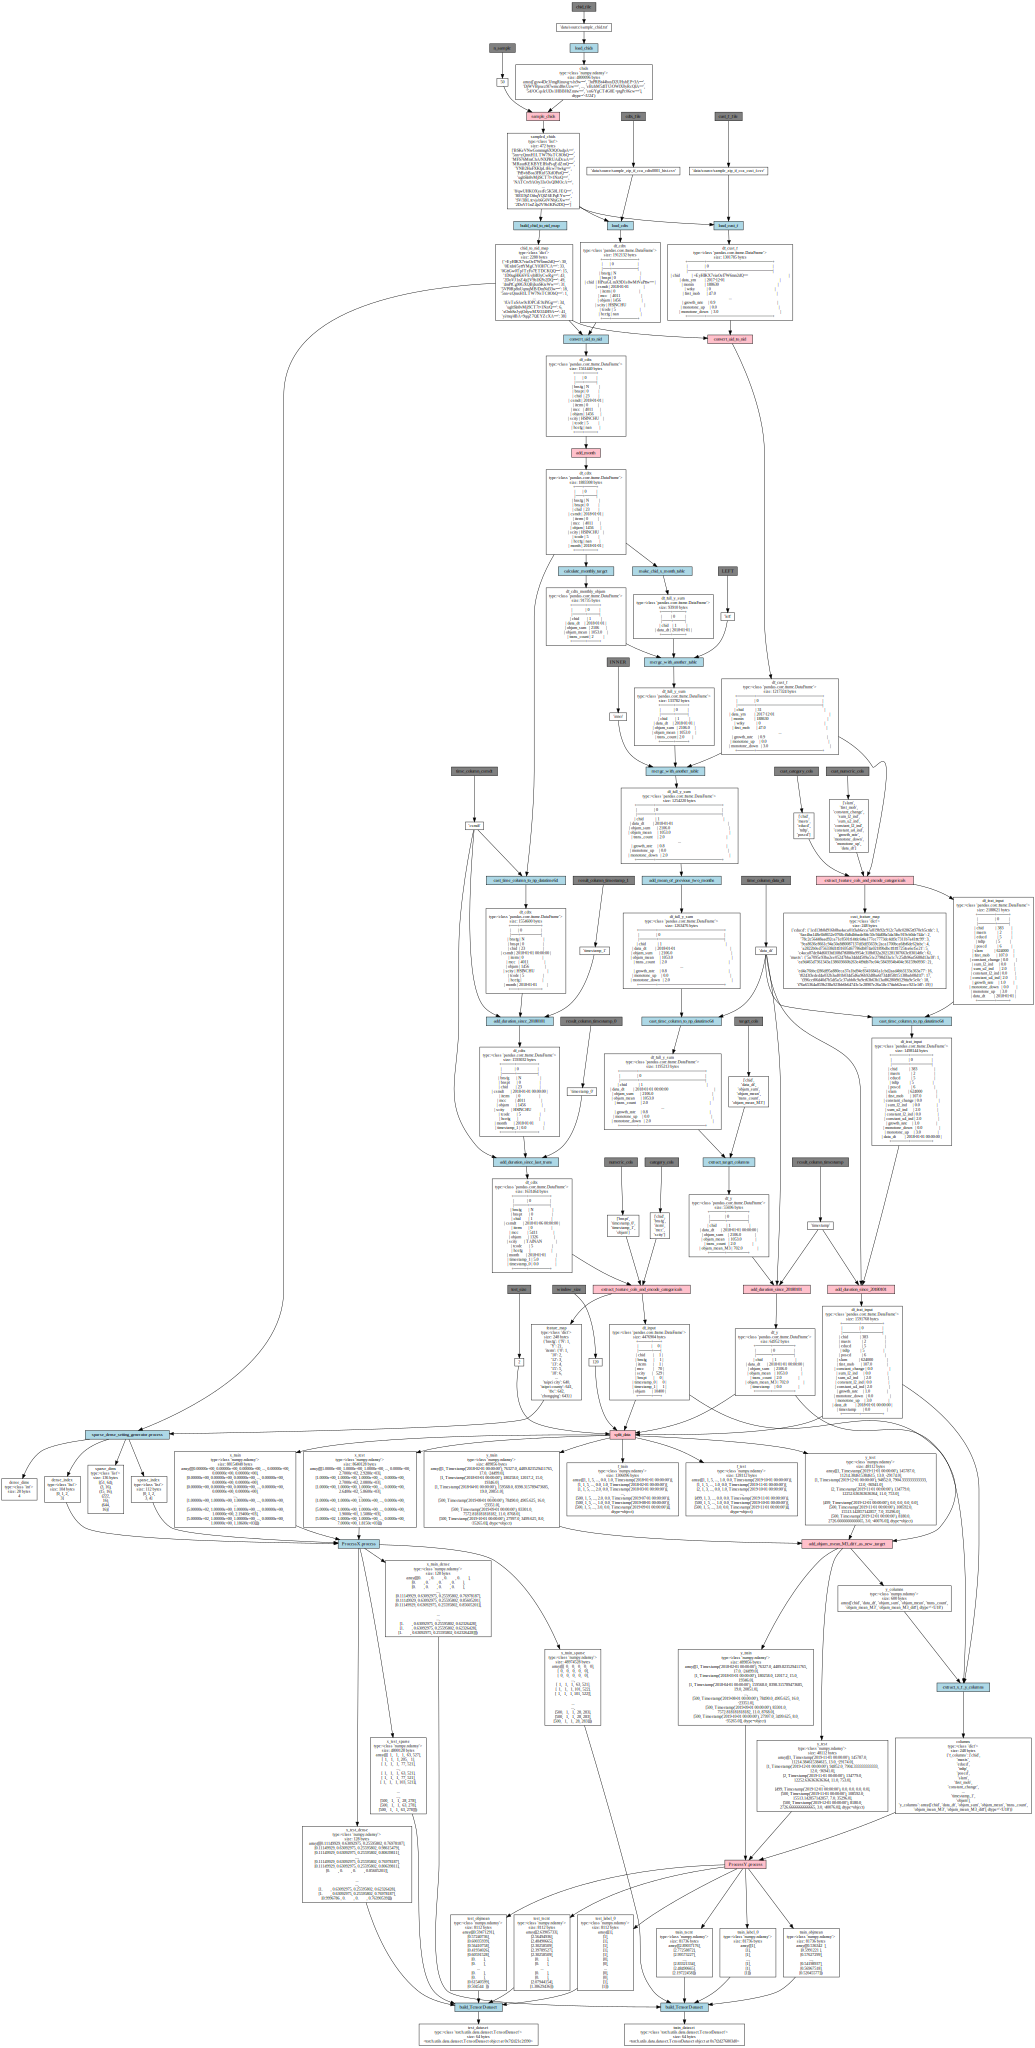

In [12]:
pipe.view(summary=False, option = 'all')

## viewing data size and type only 

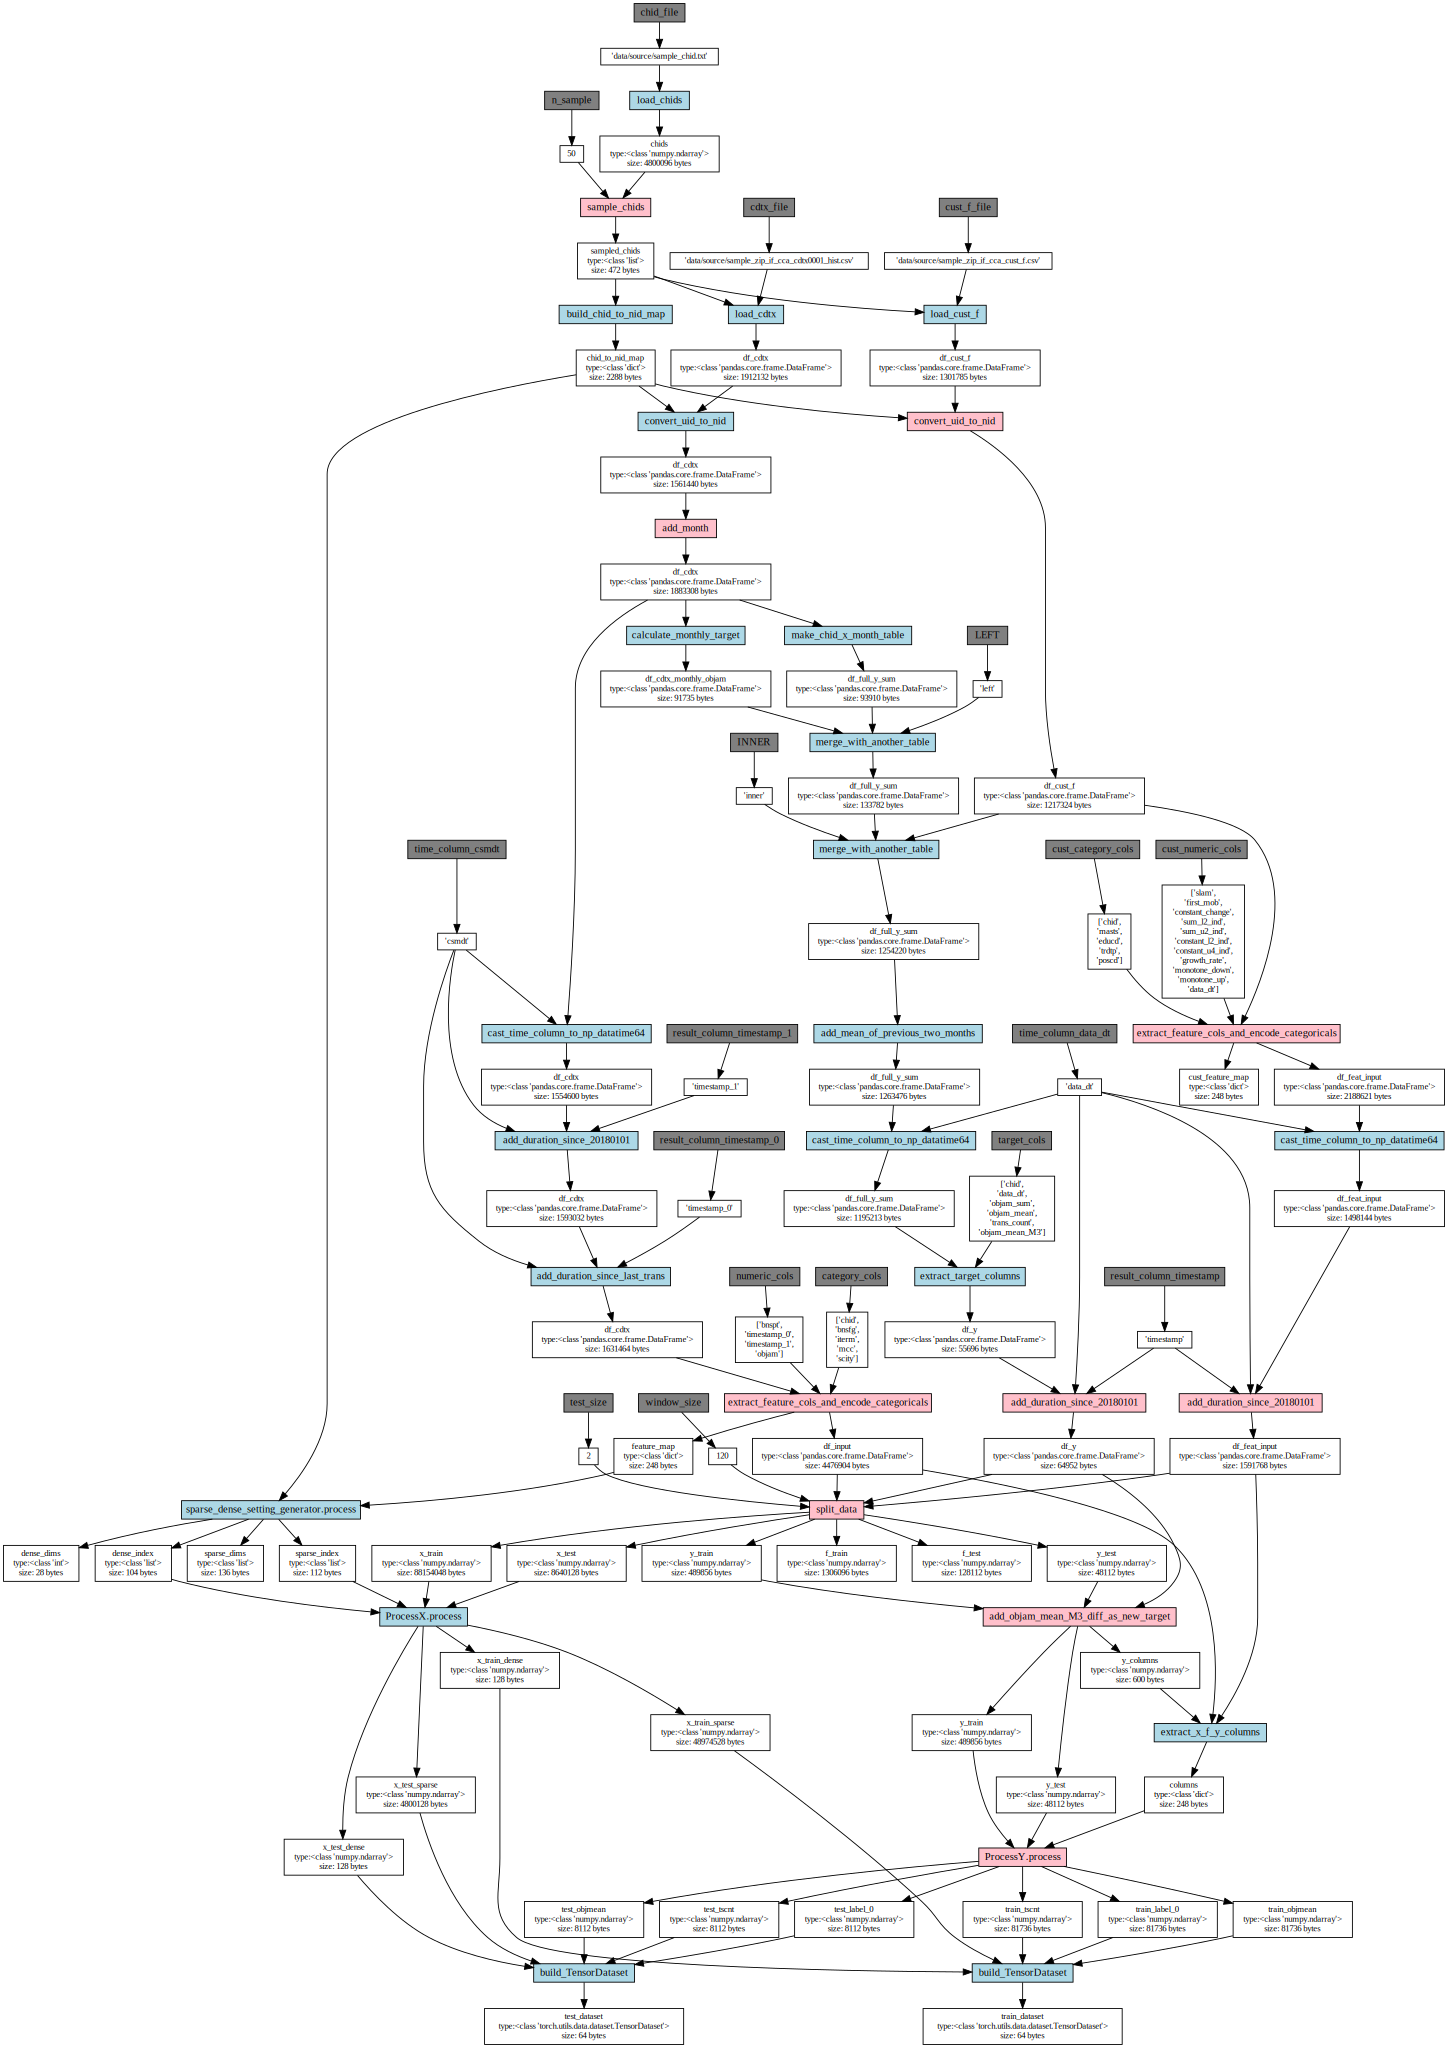

In [13]:
pipe.view(summary=False, option = 'light')

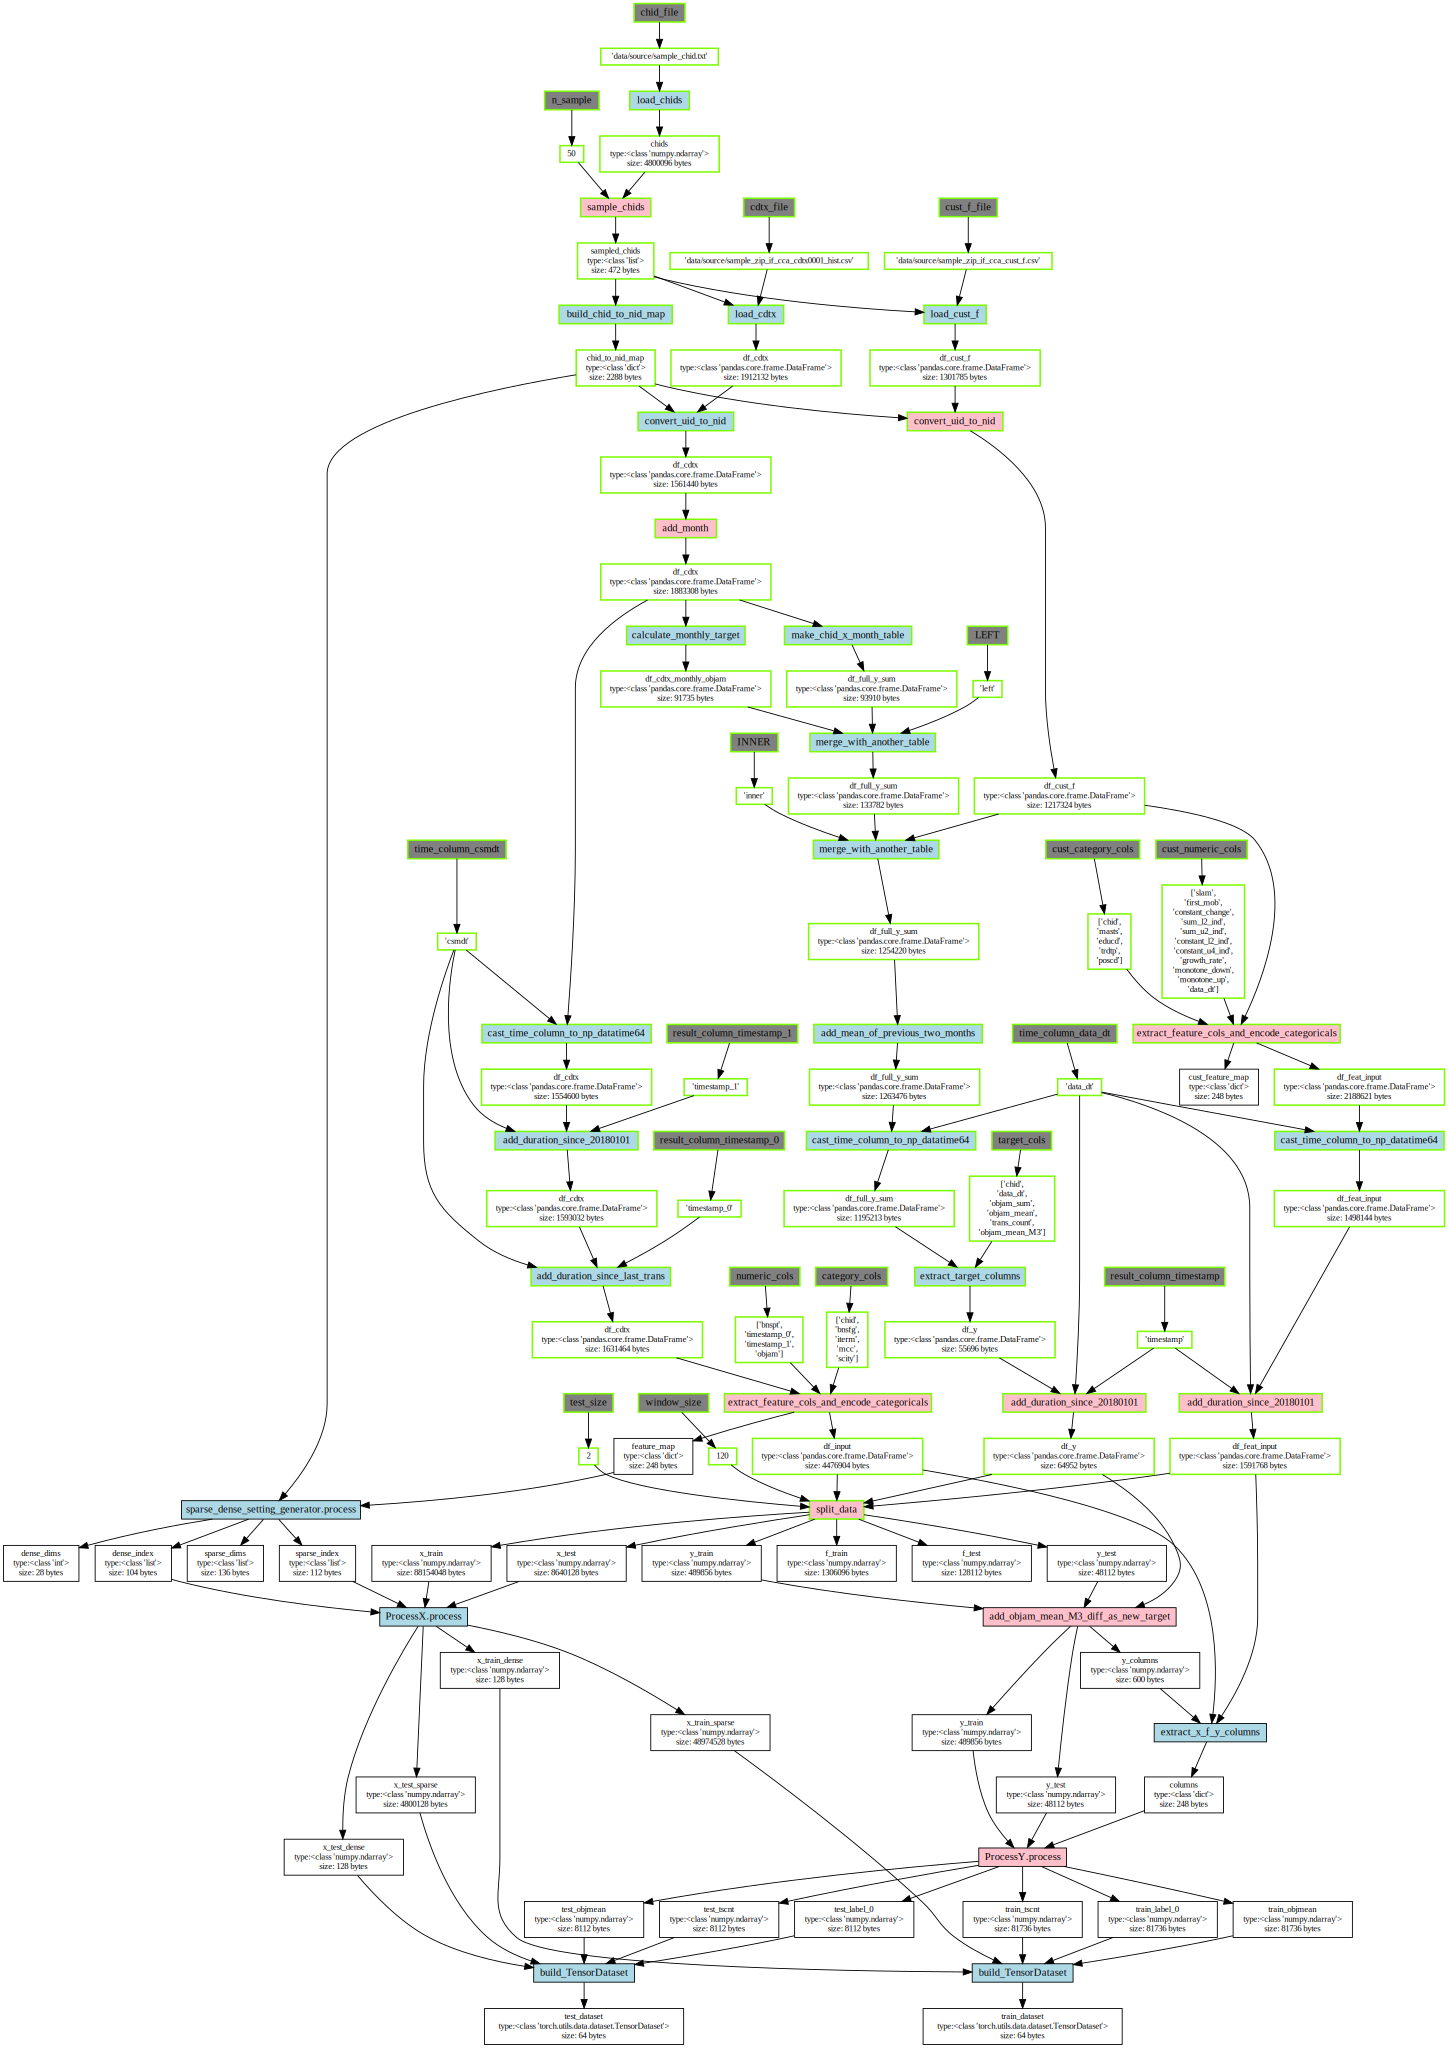

In [14]:
pipe.view_dependency('split_data',summary=False, option='light')

# Obtain values of a temporary result of the pipeline 

In [15]:
pipe.test_dataset.get(verbose=True)

[RUN] process of "process[3]"
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
[RUN] process of "process[2]"
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
[RUN] process of "process[3]"
[RUN] process of "process[4]"
[RUN] process of "process[5]"
[COMPLETE] build_TensorDataset


# Example of making modification to the pipeline 

# define new function and connect in the end 

In [16]:
@pipe._func_
def get_length(tensor_dataset):
    return len(tensor_dataset)

pipe.setup_connection('size = get_length(train_dataset)')

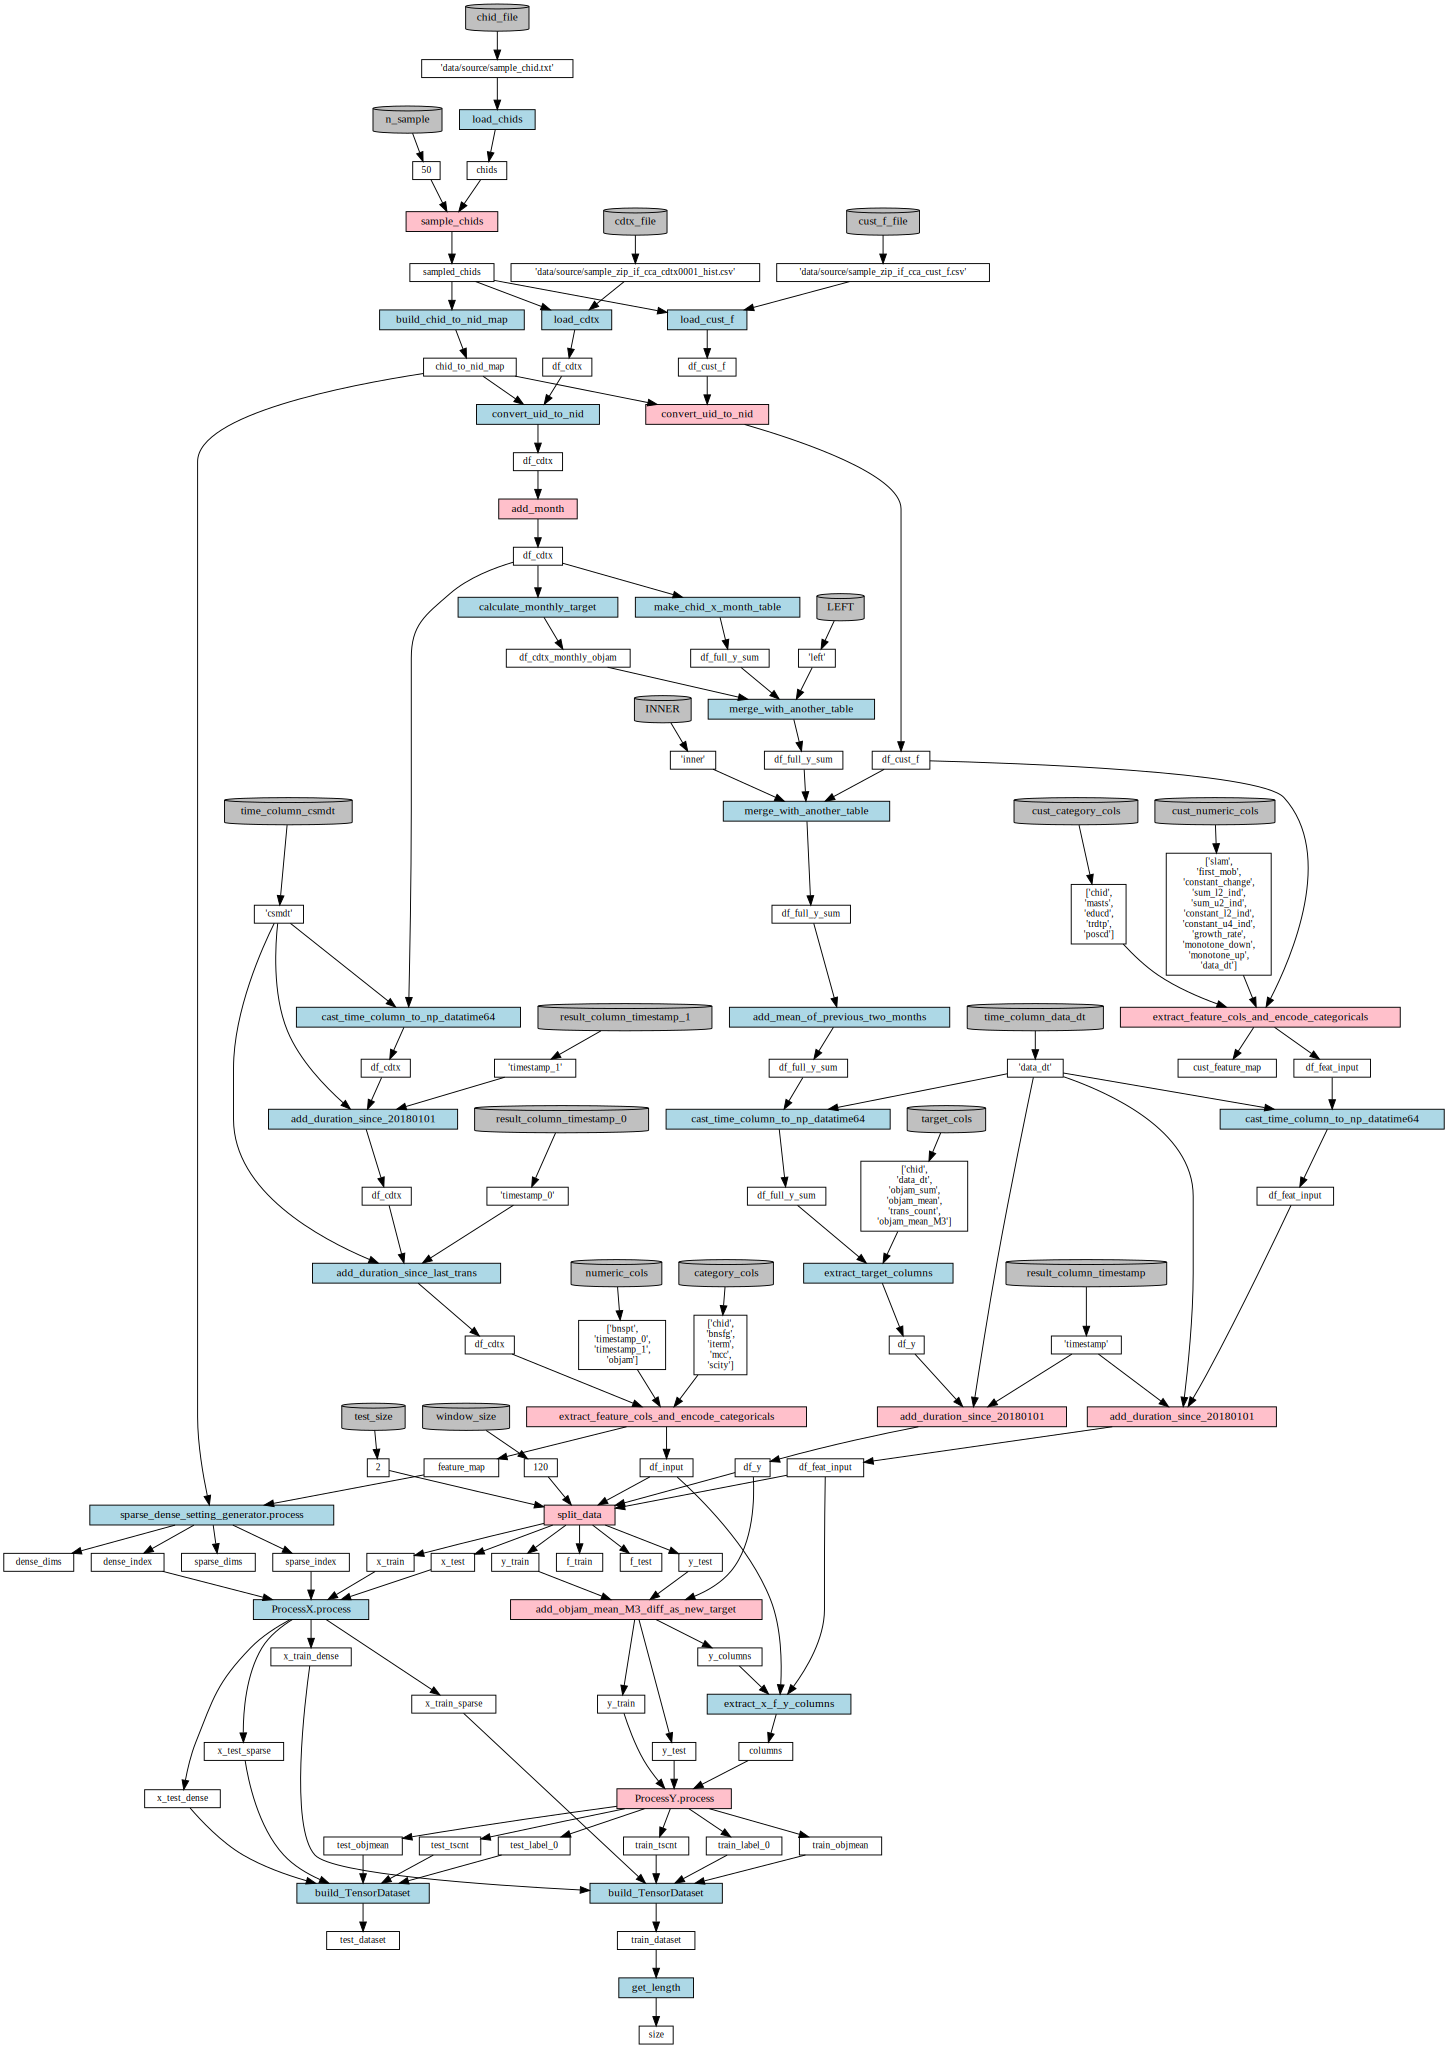

In [17]:
pipe.view(summary=False)

In [18]:
pipe.size.get()

Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features


1039

# modify a function

In [19]:
@pipe._rep_func_('build_TensorDataset')
def build_TensorDataset(x_dense, x_sparse, objmean, tscnt, label_0):
    return "Hello New TensorDataset Result!"

In [20]:
pipe.test_dataset.get()

Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features


'Hello New TensorDataset Result!'

In [21]:
pipe.train_dataset.get()

Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features


'Hello New TensorDataset Result!'